##### The latest version of this Jupyter notebook is available at [http://github.com/jckantor/CBE40455](http://github.com/jckantor/CBE20255)  for noncommercial use under terms of the [Creative Commons Attribution Noncommericial ShareAlike License](http://creativecommons.org/licenses/by-nc-sa/4.0/).

J.C. Kantor (Kantor.1@nd.edu)

# Data Reconciliation

This notebook demonstrates use of linear programming using GLPK/Mathprog for reconciliation of process measurements.

## Data Reconciliation and Gross Error Detection

The following demonstration was motivated by a former student Matt N. who was exploring methods for assessing measurement information in a refinery application. The illustration was adapted from Chapter 1 of "Reconciliation & Gross Error Detection: An Intelligent Use of Process Data" by Shankar Narasimhan and Cornelius Jordache (Gulf Publishing, 2000).

### Heat Exchanger with Bypass
<pre>
           1/1          2/2         4/3         6/5
        -------- SPLIT ----- HTEXG ----- MIXER --------
                   |                       ^ 
                   |                       |
                   |    3            5/4   |
                   +-------> VALVE --------+
</pre>

The flow sheet is labeled by `s/k` pairs which refer to stream `s` and measurement `k`. Streams are numbered `s` in `1..S` and sensors are numbered `k` in `1..K`. The parameter `s[k]` denotes the stream associated with measurement `k`.

Given sensor measurements $y_k$, the task is to infer values for the flowrates $x_{s_k}$ using mass balance equations and a sensor model

$$\begin{eqnarray}
     |y_k-x_{s_k}| & \leq & e_k + M g_k \\
     |e_k| & \leq & e^{max}_k
\end{eqnarray}$$

$g_k$ is a binary variable indicating the presence of a gross error in sensor $k$. $M$ is a big number. A gross error occurs if the measured data is not consistent with sensor model and mass balances. The optimization objective is to find an estimate of mass flows minimizing the number of gross sensor errors.

In [2]:
%%writefile DataReconciliation.dat

/* All of the relevant sensor information is given in the data section. The
relevant information includes the number of sensors, and a table indexed by 
sensor number k with information on which stream is measured (s[k]), the 
measurement (y[k]), and  'no-penalty' range for measurement errors (emax[k]). 
*/

set UNITS := SPLIT HTEXG VALVE MIXER;
set STREAMS := 1 2 3 4 5 6;

/* Mass Balance Coefficients */
param  A :
            1   2   3   4   5   6  :=
   SPLIT   -1   1   1   .   .   .
   HTEXG    .  -1   .   1   .   .
   VALVE    .   .  -1   .   1   .
   MIXER    .   .   .   1   1  -1 ;

/* Sensors and Measurement Data*/
param: SENSORS:   s      y     emax :=    
          1       1   101.91   1.75
          2       2    68.45   1.75
          3       4    64.20   1.75
          4       5    36.44   1.75
          5       6    98.88   1.75 ;

end;

Writing DataReconciliation.dat


In [3]:
%%script glpsol -m /dev/stdin -d DataReconciliation.dat --out output

# Example: DataReconciliation.mod

/* Sets */
set STREAMS;
set SENSORS;
set UNITS;

/* Mass Balances  Coefficients */
param A{UNITS,STREAMS} default 0;

/* Sensors Parameters */
param y{SENSORS} >= 0;        # Measurement Data
param s{SENSORS}  > 0;        # Stream measured by each sensor
param emax{SENSORS} >= 0;     # Bound on error for each sensor
param bigM := 100;            # Big M

/* Stream Variables */
var x{STREAMS} >= 0;

/* Sensor Variables */
var epos{SENSORS} >= 0;
var eneg{SENSORS} >= 0;
var gerr{SENSORS} binary;     # Gross Errors

/* Optimization Criterion */
minimize L1: sum {k in SENSORS} (epos[k]+eneg[k] + bigM*gerr[k]);

/* Mass Balances */
s.t. MASSBAL {i in UNITS}: sum{j in STREAMS} A[i,j]*x[j] = 0;

/* Error Model */
s.t. s_err {k in SENSORS}: y[k] =  x[s[k]] + epos[k] - eneg[k];
s.t. e_pos {k in SENSORS}: epos[k] <= emax[k] + bigM*gerr[k];
s.t. e_neg {k in SENSORS}: eneg[k] <= emax[k] + bigM*gerr[k];

/* Solve and Display Solution */
solve;

printf "Measurement Reconciliation";
printf "\n\n   Sensor    Measured     Reconciled    Difference    GrossError";
for {k in SENSORS}{
   printf "\n      %s      %7.2f       %7.2f      %7.2f",
      k,y[k],x[s[k]],(epos[k]-eneg[k]),gerr[k];
   printf "         %3s", if gerr[k]=1 then "X" else " ";
}
printf "\n\n\nStream Estimates";
printf "\n\n   Stream    Estimate";
printf {i in STREAMS} "\n      %s      %7.2f",i,x[i];

table tab1 {k in SENSORS} OUT "CSV" "MeasurementReconciliation.csv" "ColumnChart":
    k~Sensor,
    y[k]~Measurement,
    x[s[k]]~Reconciled;

table tab2 {k in SENSORS} OUT "CSV" "MeasurementError.csv" "ColumnChart":
    k~Sensor,
    (epos[k]-eneg[k])~Error;

data;

end;


## Visualization

,Sensor,Error
0,1,1.28
1,2,4.25
2,3,0.00
3,4,0.01
4,5,-1.75


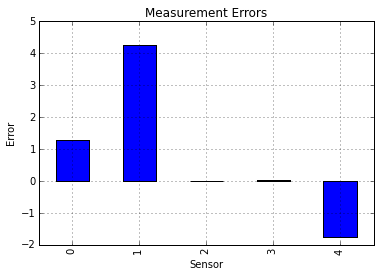

In [16]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

me = pd.read_csv("MeasurementError.csv")
display(me)
me["Error"].plot(kind="bar")

plt.title('Measurement Errors')
plt.xlabel('Sensor')
plt.ylabel('Error')
plt.grid()